Dataset - https://www.kaggle.com/ted8080/house-prices-and-images-socal?select=socal2

In [1]:
from os.path import isfile, join
import pandas as pd
import numpy as np
import cv2
from utils import *
from sklearn.utils import resample

df = pd.read_csv("data/houses/socal2.csv")
df.head()

,image_id,street,citi,n_citi,bed,bath,sqft,price
0,0,1317 Van Buren Avenue,"Salton City, CA",317,3,2.0,1560,201900
1,1,124 C Street W,"Brawley, CA",48,3,2.0,713,228500
2,2,2304 Clark Road,"Imperial, CA",152,3,1.0,800,273950
3,3,755 Brawley Avenue,"Brawley, CA",48,3,1.0,1082,350000
4,4,2207 R Carrillo Court,"Calexico, CA",55,4,3.0,2547,385100


<AxesSubplot:>

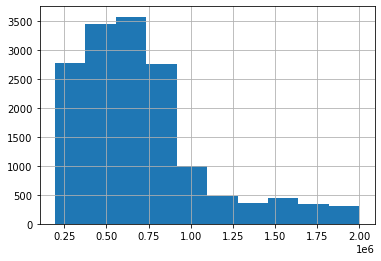

In [2]:
df.price.hist()

In [3]:
def load_dataset(df, images_path="data/houses/images", size=(32,32), gray_scale=False):
    images = []
    prices = []
    for _,row in df.iterrows():
        img_id = row.image_id
        prices.append(row.price)
        
        img = cv2.imread(join(images_path, f"{img_id}.jpg"))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if gray_scale else cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(cv2.resize(img, size))

    print(f"{len(images)} imagens carregadas")
    return np.array(images), np.array(prices)

size = (64,64)
gray_scale = True
images, prices = load_dataset(df, size=size, gray_scale=gray_scale)
if gray_scale:
    plt.gray()

15474 imagens carregadas


<Figure size 432x288 with 0 Axes>

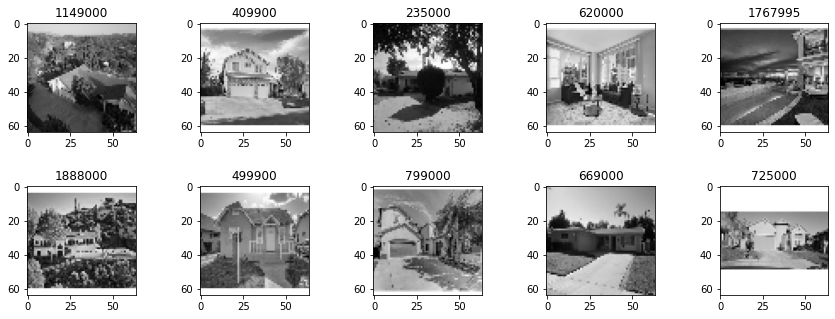

In [4]:
num_samples = 10
samples = resample(images, prices, n_samples=num_samples, replace=False)

plot_images(samples[0], labels=samples[1], rows=2)

In [5]:
from sklearn.model_selection import train_test_split

X = images_to_2d(images)
Y = prices

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

In [25]:
from models import PPCA
ppca = PPCA(200)
ppca.fit(X_train)

z = ppca.project(X_train)
x = ppca.reconstruct(z)

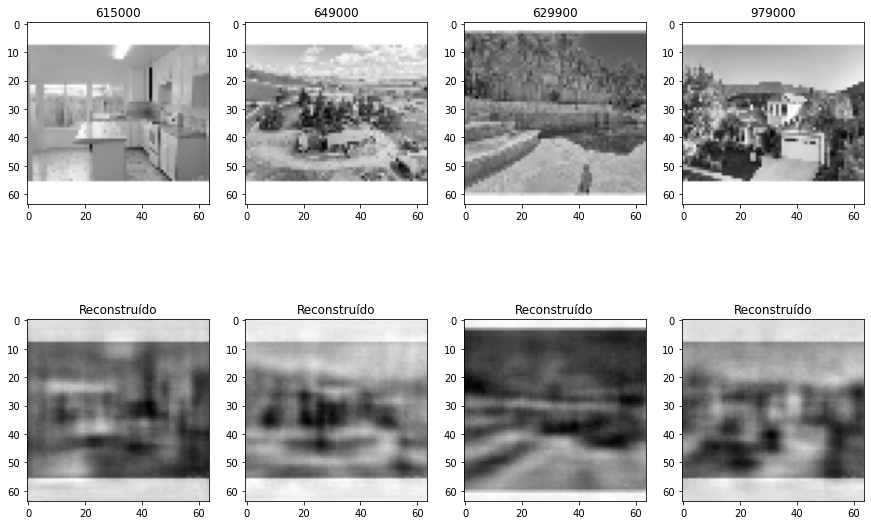

In [26]:
from sklearn.utils import resample

num_samples = 4
samples = resample(X_test, Y_test, n_samples=num_samples, replace=False)

fig = plt.figure(figsize=(15,10))
for n, (img, label) in enumerate(zip(samples[0], samples[1])):
    reconstruct = ppca.reconstruct(ppca.project(img))
    
    plt.subplot(2, num_samples, n+1)
    plt.title(label)
    plt.imshow(vector_to_image(img, size))
    
    plt.subplot(2, num_samples, n+num_samples+1)
    plt.title("Reconstruído")
    plt.imshow(vector_to_image(reconstruct, size))
    
plt.show()

In [9]:
from sklearn.metrics import mean_squared_error
from models import BayesianLinearRegression
model = BayesianLinearRegression()
model.fit(z, Y_train, alpha=1, beta=1)

predictions = model.predict(ppca.project(X_test))

baysian_regession_rmse = mean_squared_error(Y_test, predictions, squared=False)
print(f"Raiz do erro quadrado médio: {baysian_regession_rmse}")

Raiz do erro quadrado médio: 379391.73686710786


In [10]:
data = df[["bed", "bath", "sqft", "price"]].values
XX = data[:,:-1]
YY = data[:,-1]

XX_train, XX_test, YY_train, YY_test = train_test_split(XX,YY, test_size=0.2, random_state=42)

model = BayesianLinearRegression()
model.fit(XX_train, YY_train, alpha=100, beta=100)

predictions = model.predict(XX_test)

baseline_bayesian_rmse = mean_squared_error(YY_test, predictions, squared=False)
print(f"Raiz do erro quadrado médio: {baseline_bayesian_rmse}")

Raiz do erro quadrado médio: 309973.5502716218


In [21]:
import GPy
import GPyOpt

basis_functions = [identity, add_bias_parameter]

def optimizable_function(params):
    print(params.shape)
    n_components = int(params[0,0])
    alpha = params[0,1]
    beta = params[0,2]
    bf = basis_functions[int(params[0,3])]
    
    ppca = PPCA(n_components)
    ppca.fit(X_train)
    
    model = BayesianLinearRegression()
    model.fit(ppca.project(X_train), Y_train, alpha=alpha, beta=beta)

    predictions = model.predict(ppca.project(X_test))

    return mean_squared_error(Y_test, predictions, squared=False)

bounds = [
    {"name": "n_components", 'type': 'discrete', "domain": [2,10, 50, 100, 200]},
    {"name": "alpha", "type": "continuous", "domain": (1, 100)},
    {"name": "beta", "type": "continuous", "domain": (1, 100)},
    {"name": "basis function", "type": "categorical", "domain": np.arange(len(basis_functions))}
]

optimizer = GPyOpt.methods.BayesianOptimization(optimizable_function, bounds, verbosity=True,
                                               initial_design_type='latin',
                                               acquisition_type='MPI')
optimizer.run_optimization(15) # max itter

(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)


In [22]:
params = optimizer.x_opt
n_components = int(params[0])
alpha = params[1]
beta = params[2]
    
rmse = optimizer.fx_opt
print("Resultados da otimização:")
print(f"Raiz do erro quadrado médio: {rmse}\nespaço latente: {n_components}\nalpha: {alpha}\nbeta: {beta}")

Resultados da otimização:
Raiz do erro quadrado médio: 376954.84922102734
espaço latente: 50
alpha: 50.5
beta: 50.5
